In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import limepy

import numpy as np
import scipy as sp
import astropy.units as u
import astropy.constants as const

from binaryshift import BinaryShift

In [2]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.468, -1.178, -2.117]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [3]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=100,
)

/home/peter/research/ssptools/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1
/home/peter/research/ssptools/ssptools/evolve_mf_3.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  Aj = Nj / self.Pk(alphaj, 1, m1, mto)


In [4]:
f

In [5]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])

In [6]:
print(mj[:nms])

[0.11851084 0.16351292 0.22560363 0.31127202 0.42947124 0.53616312
 0.6158897  0.70747148 0.80754321]


In [7]:
print("mj  | q: 0.5 \t 0.75 \t 0.95")
print("-------------------------------")
for i in range(nms):
    print(f"{mj[i]:.2f} \t {mj[i]*0.5:.3f} \t {mj[i]*0.75:.3f} \t {mj[i]*0.95:.3f}")

mj  | q: 0.5 	 0.75 	 0.95
-------------------------------
0.12 	 0.059 	 0.089 	 0.113
0.16 	 0.082 	 0.123 	 0.155
0.23 	 0.113 	 0.169 	 0.214
0.31 	 0.156 	 0.233 	 0.296
0.43 	 0.215 	 0.322 	 0.408
0.54 	 0.268 	 0.402 	 0.509
0.62 	 0.308 	 0.462 	 0.585
0.71 	 0.354 	 0.531 	 0.672
0.81 	 0.404 	 0.606 	 0.767


In [8]:
bs = BinaryShift(mj=mj, Mj=Mj, MF=f, verbose=True)

In [9]:
bs.dump()

self.mj = array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])
self.Mj = array([3.50653839e+03, 5.74173527e+03, 9.40172964e+03, 1.53947409e+04,
       2.52079221e+04, 1.45666174e+04, 1.63248118e+04, 1.82952210e+04,
       1.85600328e+04, 4.28216163e+04, 3.68811585e+04, 8.56110667e+03,
       8.87107346e+03, 2.04048921e+04, 2.87933957e+03, 3.38905042e+00,
       6.98416820e+00, 1.30644215e+01, 2.60412400e+01, 5.68695470e+01,
       4.17703060e+01])
self.nms = 8
self.mWD_max = 1.2485309234871975
self.mBH_min = 2.51188643150958


In [10]:
bs.BH_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True])

In [11]:
mj_new, Mj_new = bs.shift_q_dist(fb=[0.1, 0.1, 0.1], q=[0.3, 0.5, 0.7])


current mj: 0.119
companion_mass = 0.036
companion mass 0.036 smaller than 0.119, skipping

current mj: 0.164
companion_mass = 0.049
companion mass 0.049 smaller than 0.119, skipping

current mj: 0.226
companion_mass = 0.068
companion mass 0.068 smaller than 0.119, skipping

current mj: 0.311
companion_mass = 0.093
companion mass 0.093 smaller than 0.119, skipping

current mj: 0.429
companion_mass = 0.129
closest companion_idx = 0
closest companion_mass = 0.119
new mass: 0.548 

current mj: 0.536
companion_mass = 0.161
closest companion_idx = 1
closest companion_mass = 0.164
new mass: 0.700 

current mj: 0.616
companion_mass = 0.185
closest companion_idx = 1
closest companion_mass = 0.164
new mass: 0.779 

current mj: 0.707
companion_mass = 0.212
closest companion_idx = 2
closest companion_mass = 0.226
new mass: 0.933 

current mj: 0.119
companion_mass = 0.059
companion mass 0.059 smaller than 0.119, skipping

current mj: 0.164
companion_mass = 0.082
companion mass 0.082 smaller than 

(0.0, 1.7)

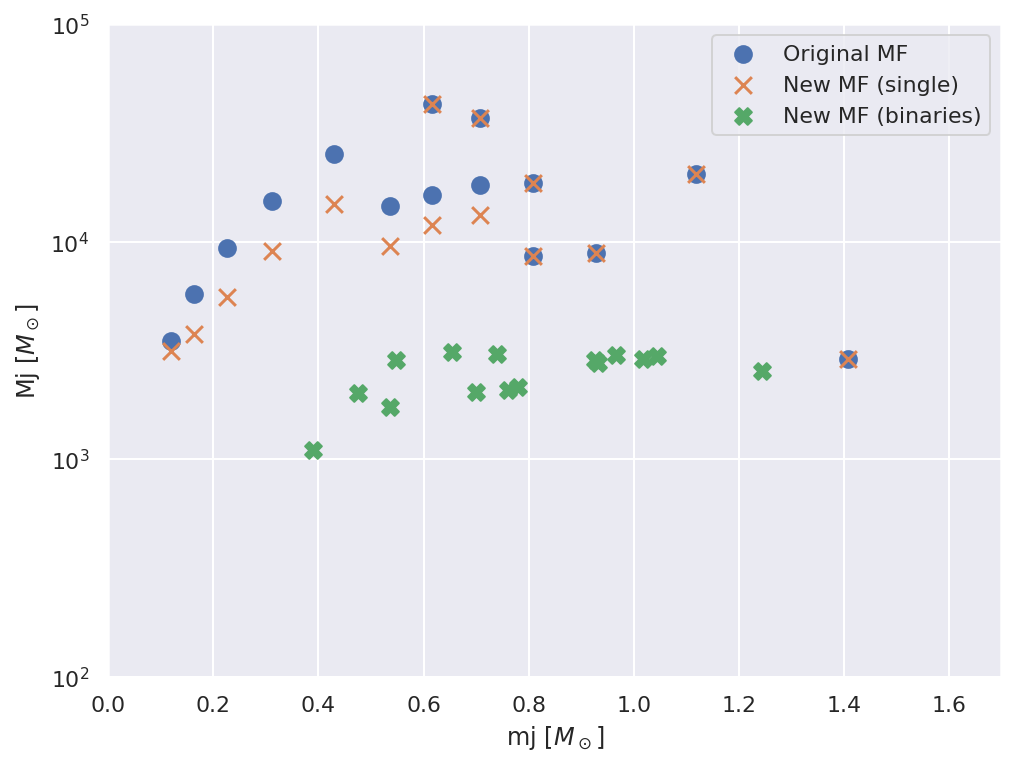

In [12]:
plt.figure()
plt.scatter(mj, Mj, label="Original MF", s=70)
plt.yscale("log")
plt.ylim(1e2,1e5)
plt.scatter(mj_new[~bs.bin_mask], Mj_new[~bs.bin_mask], label="New MF (single)", marker="x", s=70)
plt.scatter(mj_new[bs.bin_mask], Mj_new[bs.bin_mask], label="New MF (binaries)", marker="X", s=70)
plt.legend()
plt.ylabel(r"Mj [$M_\odot$]")
plt.xlabel(r"mj [$M_\odot$]")
plt.xlim(0, 1.7)

In [13]:
mj

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])

In [14]:
mj_new

array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993, 0.54798207, 0.69967604, 0.77940262, 0.93307511,
       0.47478494, 0.65507486, 0.76176675, 0.92716171, 1.0187435 ,
       0.38911655, 0.53687564, 0.74074325, 0.96563436, 1.04536093,
       1.2436346 ])

In [15]:
bs.bin_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [16]:
bs.dump()

self.mj = array([0.11851084, 0.16351292, 0.22560363, 0.31127202, 0.42947124,
       0.53616312, 0.6158897 , 0.70747148, 0.80754321, 0.6158897 ,
       0.70747148, 0.80754321, 0.92779583, 1.11896564, 1.40869427,
       2.81071458, 3.53848001, 4.45468241, 5.60811288, 7.06019582,
       8.88825993])
self.Mj = array([3.50653839e+03, 5.74173527e+03, 9.40172964e+03, 1.53947409e+04,
       2.52079221e+04, 1.45666174e+04, 1.63248118e+04, 1.82952210e+04,
       1.85600328e+04, 4.28216163e+04, 3.68811585e+04, 8.56110667e+03,
       8.87107346e+03, 2.04048921e+04, 2.87933957e+03, 3.38905042e+00,
       6.98416820e+00, 1.30644215e+01, 2.60412400e+01, 5.68695470e+01,
       4.17703060e+01])
self.q = array([0.3, 0.5, 0.7])
self.fb = array([0.1, 0.1, 0.1])
self.nms = 8
self.mWD_max = 1.2485309234871975
self.mBH_min = 2.51188643150958


In [17]:
print(f"{np.sum(Mj) = :.3f}, {np.sum(Mj_new) = :.3f}")

np.sum(Mj) = 247566.655, np.sum(Mj_new) = 247566.655


In [18]:
l = limepy(M=1e6,phi0=6,g=0.8,mj=mj,Mj=Mj,delta=0.45,rh=8,ra=10**1.23,project=True)

In [19]:
l_bin = limepy(M=1e6,phi0=6,g=0.8,mj=mj_new,Mj=Mj_new,delta=0.45,rh=8,ra=10**1.23, project=True)

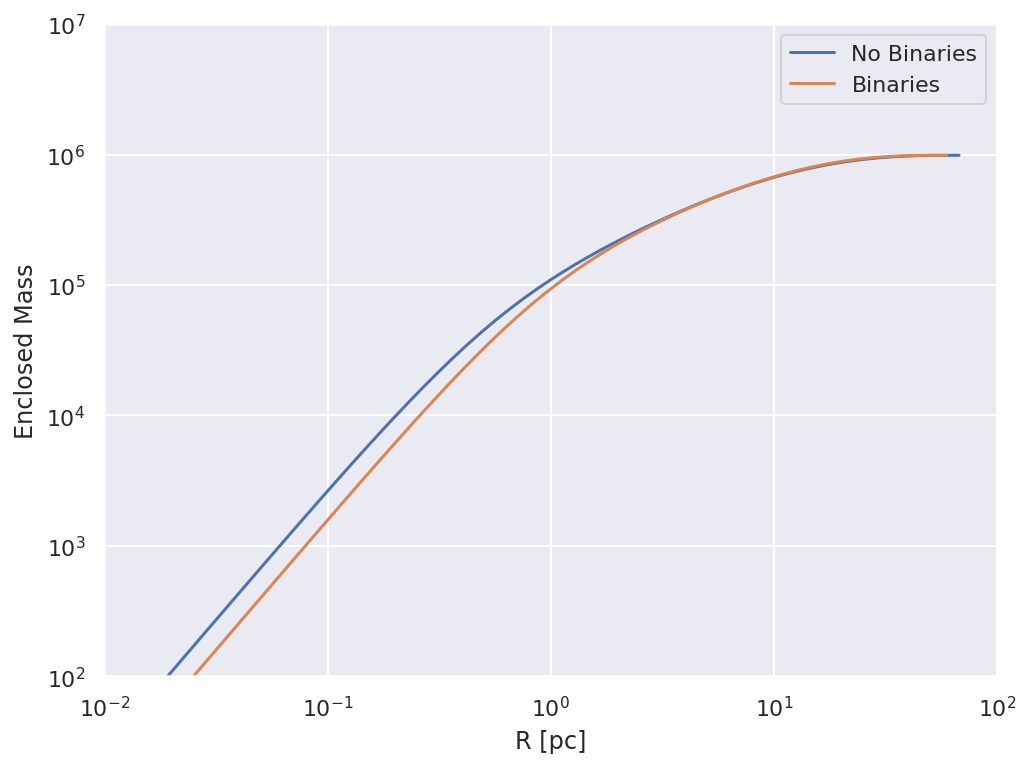

In [20]:
plt.figure()
plt.loglog()
plt.xlim(1e-2,1e2)
plt.ylim(1e2,1e7)
plt.plot(l.r,l.mcp, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Enclosed Mass")
plt.plot(l_bin.r, l_bin.mcp, label="Binaries")
plt.legend()

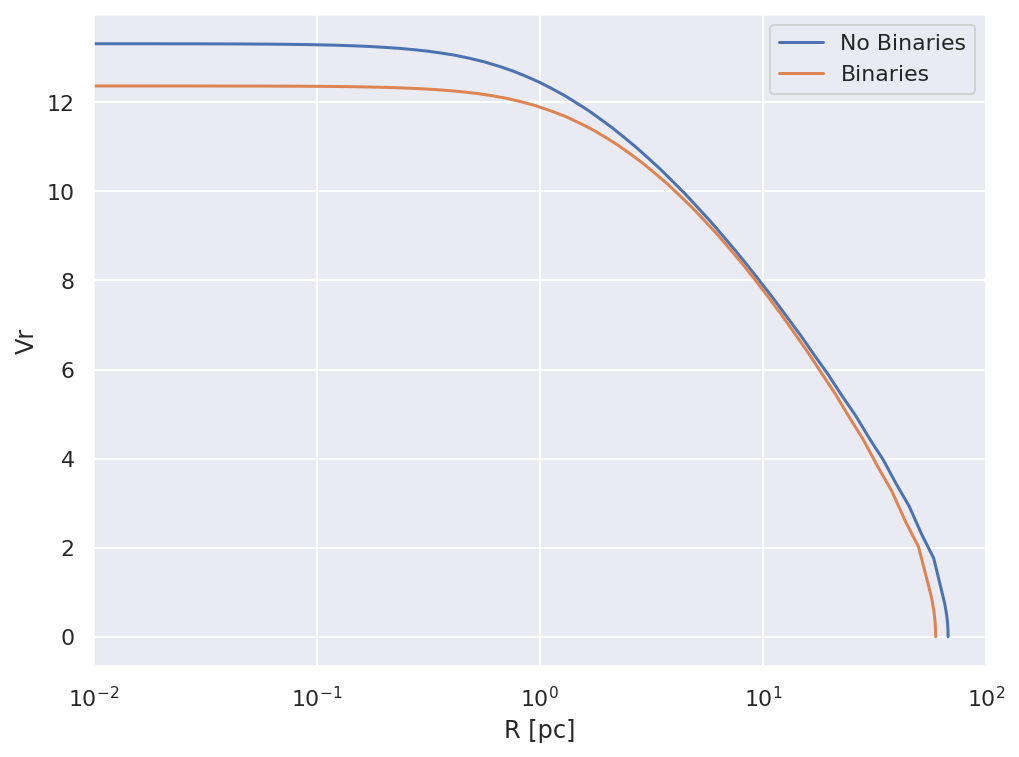

In [21]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2,1e2)
plt.plot(l.r,np.sqrt(l.v2R), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vr")
plt.plot(l_bin.r, np.sqrt(l_bin.v2R), label="Binaries")
plt.legend()

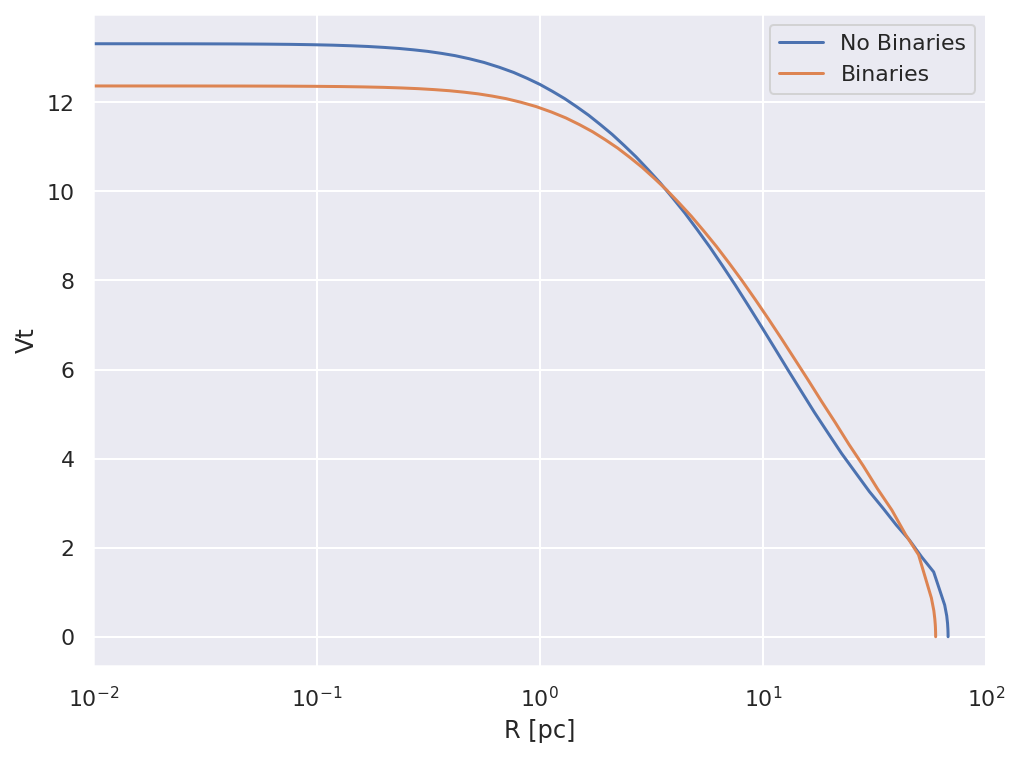

In [22]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2,1e2)
plt.plot(l.r,np.sqrt(l.v2T), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vt")
plt.plot(l_bin.r, np.sqrt(l_bin.v2T), label="Binaries")
plt.legend()

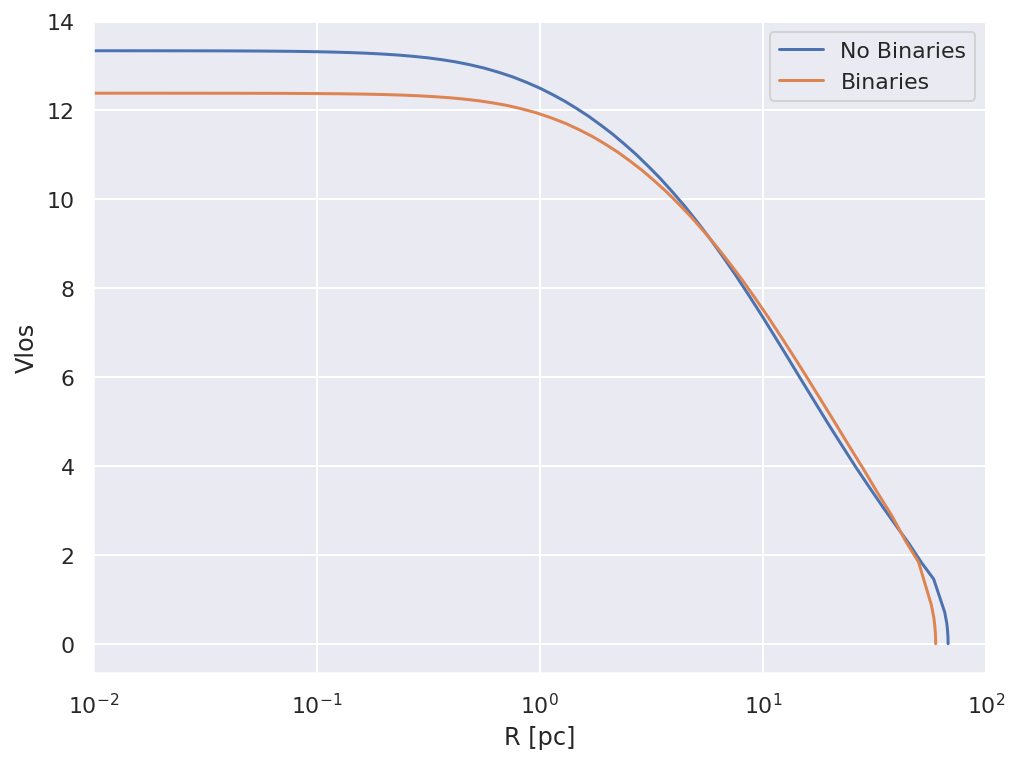

In [23]:
plt.figure()
plt.xscale("log")
plt.xlim(1e-2,1e2)
plt.plot(l.r,np.sqrt(l.v2p), label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel("Vlos")
plt.plot(l_bin.r, np.sqrt(l_bin.v2p), label="Binaries")
plt.legend()

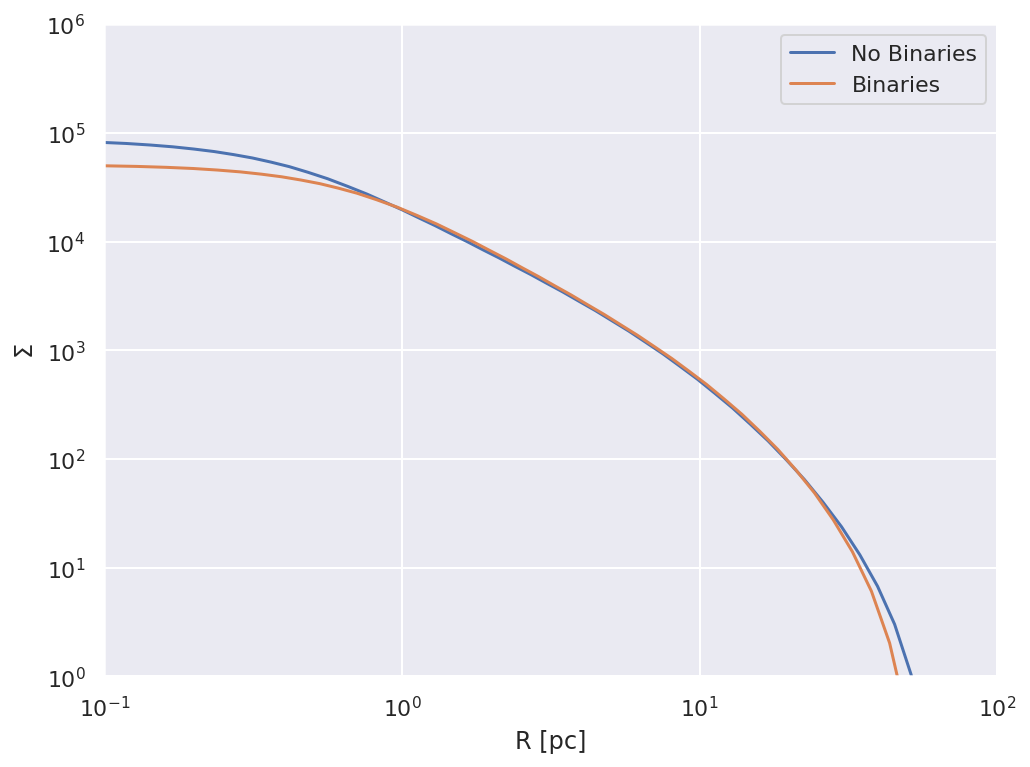

In [24]:
plt.figure()
plt.loglog()
plt.xlim(1e-1,1e2)
plt.ylim(1e-0,1e6)
plt.plot(l.r,l.Sigma, label="No Binaries")
plt.xlabel("R [pc]")
plt.ylabel(r"$\Sigma$")
plt.plot(l_bin.r, l_bin.Sigma, label="Binaries")
plt.legend()